# Prediccion de sitios web phishing

## Fase #1: Comprension del negocio
Una empresa de ciberseguridad quiere implementar un software de deteccion de sitios web phishing, y asi evitar estafas hacia sus clientes.
Para este proposito uitilizaremos uno de los repositorios de `UCI Machine Learning Repository`: https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset  

Para una correcta comprension de los resultados, el proyecto utilizara un modelo de clasificacion y medira su exito con una precision del 90%. 

## Fase #2: Comprension de los datos

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import scipy.stats as stats


df = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')

df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [43]:
df.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,...,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,...,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000,1.000000
max,6097.000000,110.000000,1.000000,100.000000,1.000000,0.522907,0.090824,13.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,8956.000000,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000,1.000000


## Fase #3: Preparacion de los datos
### Las variables mas importantes para la deteccion de phishing son:

* `IsDomaInIP`
    * Los sitios legitimos rara vez usan una direccion IP numerica en el dominio.
* `URLLength`
    * Las URL de phishing suelen ser extensas para confundir al usuario.
* `NoOfSubdomains`
    * Un numero alto de subdominios, especialmente si son sospechosos, es señal de alerta.
* `TLDLegitimateProb`
    * Algunos TLDs son más usados para phishing que otros (por ejemplo .xyz o .top).
* `HasObfuscation` y `ObfuscationRatio`
    *  La ofuscación en la URL (ej. caracteres especiales) es una táctica común de phishing para evadir la detección y confundir al usuario.
* `NoOfURLRedirect`
    * Los sitios de phishing a menudo utilizan múltiples redirecciones para dirigir a los usuarios a la página falsa, ocultando la URL original.
* `IsHTTPS` 
    * Es un factor no defenitivo, pero que puede ayudar.
* `HasExternalFormSubmit`
    *  Si un formulario de inicio de sesión envía datos a un dominio diferente al de la página actual.
* `NoOfPopup`
    * Muchos sitios de phishing utilizan popups para solicitar información o para redirigir
* `NoOfiFrame`
    * Los iframes pueden usarse para incrustar contenido malicioso o para superponer elementos sobre la página legítima
* `HasPasswordField`
    * Un sitio de phishing casi siempre tendrá un campo de contraseña para robar credenciales. La ausencia de este en un sitio que debería tenerlo (ej. banco) o su presencia en un sitio que no debería, es relevante.
* `Bank, Pay, Crypto`
    *  Estas son variables binarias que indican si el sitio contiene palabras clave muy sensibles. Los sitios de phishing se dirigen comúnmente a estas categorías.
* `SpacialCharRatioInURL`
    * Muchos caracteres especiales en la URL son sospechosos.
* `NoOfImage, NoOfCSS, NoOfJS`
    * Los sitios phishing suelen tener menos contenido o scripts.
* `label`
    * Label 1 corresponde a una URL legitima, label 0 a una URL de phishing.

In [44]:
# Filtramos el DataFrame para quedarnos con las variables que nos interesan
df = df[['IsDomainIP', 'URLLength', 'NoOfSubDomain', 'TLDLegitimateProb', 'HasObfuscation', 'ObfuscationRatio', 'NoOfURLRedirect',
         'IsHTTPS', 'HasExternalFormSubmit', 'NoOfPopup', 'NoOfiFrame', 'HasPasswordField', 'Bank', 'Crypto', 'Pay', 'SpacialCharRatioInURL',
         'NoOfImage', 'NoOfCSS', 'NoOfJS', 'label']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   IsDomainIP             235795 non-null  int64  
 1   URLLength              235795 non-null  int64  
 2   NoOfSubDomain          235795 non-null  int64  
 3   TLDLegitimateProb      235795 non-null  float64
 4   HasObfuscation         235795 non-null  int64  
 5   ObfuscationRatio       235795 non-null  float64
 6   NoOfURLRedirect        235795 non-null  int64  
 7   IsHTTPS                235795 non-null  int64  
 8   HasExternalFormSubmit  235795 non-null  int64  
 9   NoOfPopup              235795 non-null  int64  
 10  NoOfiFrame             235795 non-null  int64  
 11  HasPasswordField       235795 non-null  int64  
 12  Bank                   235795 non-null  int64  
 13  Crypto                 235795 non-null  int64  
 14  Pay                    235795 non-nu

In [45]:
df.head()

,IsDomainIP,URLLength,NoOfSubDomain,TLDLegitimateProb,HasObfuscation,ObfuscationRatio,NoOfURLRedirect,IsHTTPS,HasExternalFormSubmit,NoOfPopup,NoOfiFrame,HasPasswordField,Bank,Crypto,Pay,SpacialCharRatioInURL,NoOfImage,NoOfCSS,NoOfJS,label
0,0,31,1,0.522907,0,0.0,0,1,0,0,1,0,1,0,0,0.032,34,20,28,1
1,0,23,1,0.032650,0,0.0,0,1,0,0,0,0,0,0,0,0.087,50,9,8,1
2,0,29,2,0.028555,0,0.0,0,1,0,0,0,0,0,0,0,0.069,10,2,7,1
3,0,26,1,0.522907,0,0.0,0,1,0,1,12,0,0,1,1,0.038,3,27,15,1
4,0,33,1,0.079963,0,0.0,1,1,0,0,2,0,1,0,1,0.030,244,15,34,1


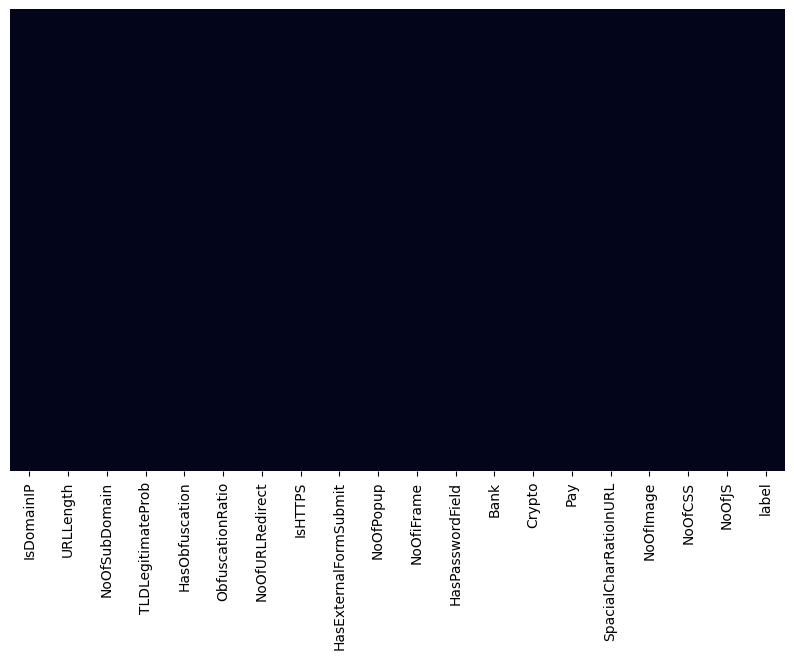

In [46]:
# Mostrar filas con valores nulos
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.show()

In [47]:
# No aseguramos de que cada columna tenga el tipo de dato correcto
df['IsDomainIP'] = df['IsDomainIP'].astype(bool)
df['IsHTTPS'] = df['IsHTTPS'].astype(bool)
df['HasObfuscation'] = df['HasObfuscation'].astype(bool)
df['Bank'] = df['Bank'].astype(bool)
df['Crypto'] = df['Crypto'].astype(bool)
df['Pay'] = df['Pay'].astype(bool)
df['label'] = df['label'].astype(bool)
df['HasExternalFormSubmit'] = df['HasExternalFormSubmit'].astype(bool)
df['HasPasswordField'] = df['HasPasswordField'].astype(bool)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   IsDomainIP             235795 non-null  bool   
 1   URLLength              235795 non-null  int64  
 2   NoOfSubDomain          235795 non-null  int64  
 3   TLDLegitimateProb      235795 non-null  float64
 4   HasObfuscation         235795 non-null  bool   
 5   ObfuscationRatio       235795 non-null  float64
 6   NoOfURLRedirect        235795 non-null  int64  
 7   IsHTTPS                235795 non-null  bool   
 8   HasExternalFormSubmit  235795 non-null  bool   
 9   NoOfPopup              235795 non-null  int64  
 10  NoOfiFrame             235795 non-null  int64  
 11  HasPasswordField       235795 non-null  bool   
 12  Bank                   235795 non-null  bool   
 13  Crypto                 235795 non-null  bool   
 14  Pay                    235795 non-nu

C:\Users\cifu1\AppData\Local\Temp\ipykernel_10524\479828605.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set1')


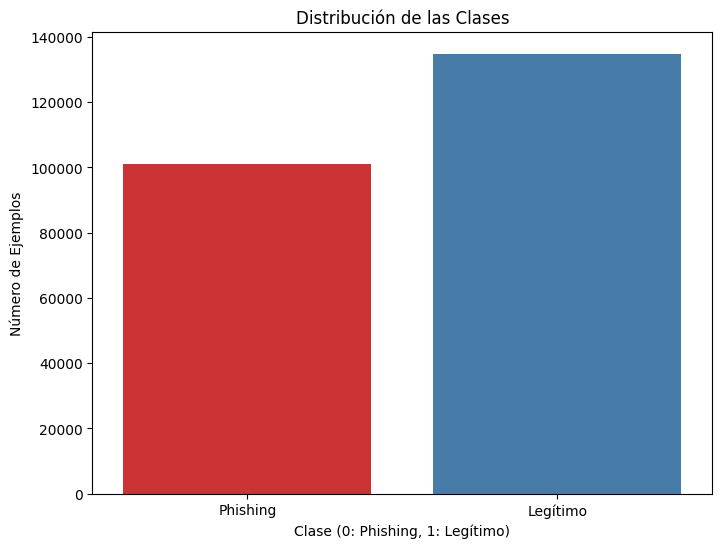

In [48]:
# Comprobamos si hay desbalance en las clases
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='Set1')
plt.title('Distribución de las Clases')
plt.xlabel('Clase (0: Phishing, 1: Legítimo)')
plt.ylabel('Número de Ejemplos')
plt.xticks([0, 1], ['Phishing', 'Legítimo'])
plt.show()

In [49]:
# Conteo de los sitios web legítimos y de phishing
legit_count = df[df['label'] == 1].shape[0]
phishing_count = df[df['label'] == 0].shape[0]
print(f"Número de sitios web legítimos: {legit_count}")
print(f"Número de sitios web de phishing: {phishing_count}")

Número de sitios web legítimos: 134850
Número de sitios web de phishing: 100945


C:\Users\cifu1\AppData\Local\Temp\ipykernel_10524\2089758892.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_resampled, palette='Set1')


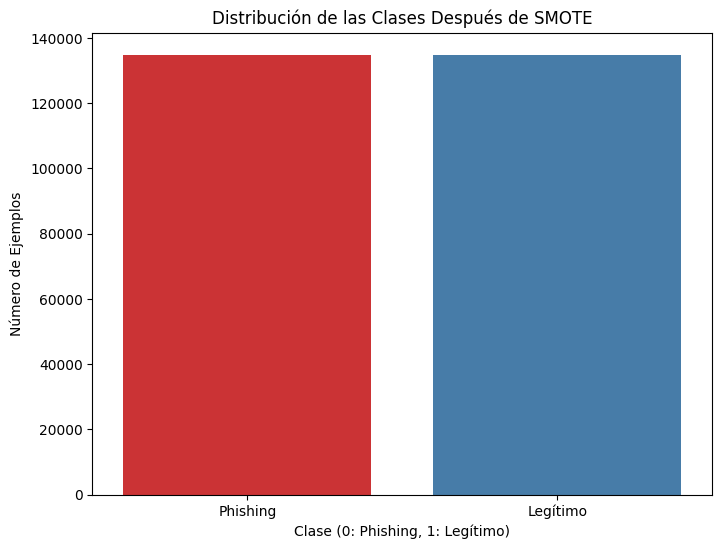

In [50]:
# Aplicamos SMOTE para balancear las clases
X = df.drop('label', axis=1)
y = df['label']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Convertimos el resultado a un DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['label'] = y_resampled
# Comprobamos la distribución de las clases después de aplicar SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_resampled, palette='Set1')
plt.title('Distribución de las Clases Después de SMOTE')
plt.xlabel('Clase (0: Phishing, 1: Legítimo)')
plt.ylabel('Número de Ejemplos')
plt.xticks([0, 1], ['Phishing', 'Legítimo'])
plt.show()

In [51]:
# Conteo de los sitios web legítimos y de phishing después de SMOTE
legit_count_resampled = df_resampled[df_resampled['label'] == 1].shape[0]
phishing_count_resampled = df_resampled[df_resampled['label'] == 0].shape[0]
print(f"Número de sitios web legítimos después de SMOTE: {legit_count_resampled}")
print(f"Número de sitios web de phishing después de SMOTE: {phishing_count_resampled}")

Número de sitios web legítimos después de SMOTE: 134850
Número de sitios web de phishing después de SMOTE: 134850


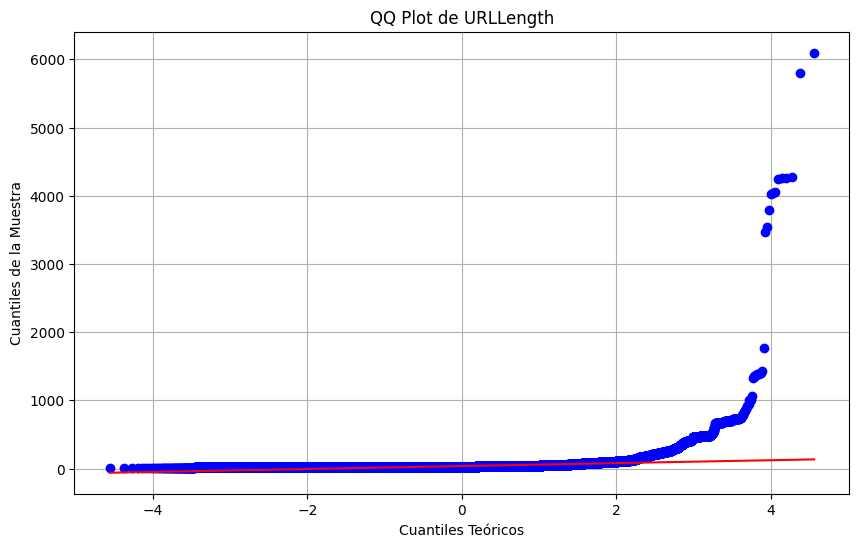

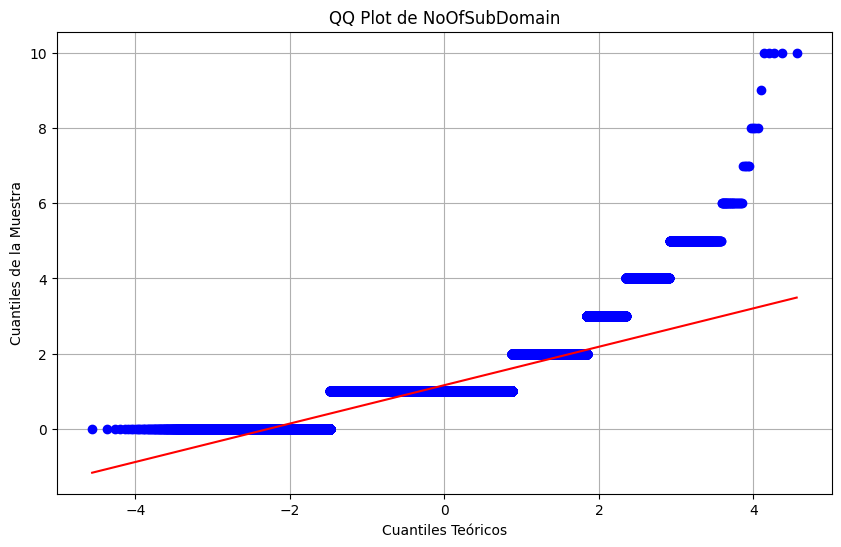

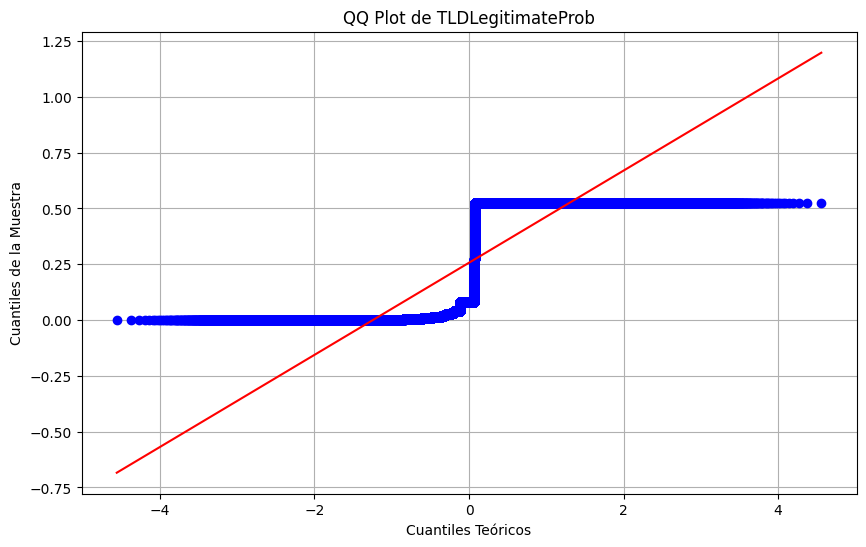

In [52]:
# QQ plot para URLLength
plt.figure(figsize=(10, 6))
stats.probplot(df_resampled['URLLength'], dist="norm", plot=plt)
plt.title('QQ Plot de URLLength')
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de la Muestra')
plt.grid()
plt.show()

# QQ plot para NoOfSubDomain
plt.figure(figsize=(10, 6))
stats.probplot(df_resampled['NoOfSubDomain'], dist="norm", plot=plt)
plt.title('QQ Plot de NoOfSubDomain')
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de la Muestra')
plt.grid()
plt.show()

# QQ plot para TLDLegitimateProb
plt.figure(figsize=(10, 6))
stats.probplot(df_resampled['TLDLegitimateProb'], dist="norm", plot=plt)
plt.title('QQ Plot de TLDLegitimateProb')
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de la Muestra')
plt.grid()
plt.show()

## Fase #4: Modelado